In [ ]:
!pip install wandb
!pip install einops
!pip install matplotlib
!wandb login ...

In [1]:
import os, random, torch  #, wandb
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.cuda.amp import GradScaler, autocast
from einops import rearrange
from torch.optim import Adam
from torch import einsum
from math import sqrt
from time import time

### define GELU activation, LayerNorm module, GPT Layer, and GPT

In [2]:
# GELU(x) = x * ϕ(x) where ϕ is the CDF of the Gaussian distribution
class GELU(nn.Module):
  def forward(self, x):
    return x * 0.5 * (1 + torch.erf(x / sqrt(2)))

In [3]:
class LayerNorm(nn.Module):
  def __init__(self, d, eps=1e-5):
    super().__init__()
    self.d, self.eps = d, eps
    self.w = nn.Parameter(torch.tensor(1.))
    self.b = nn.Parameter(torch.tensor(0.))

  def forward(self, x):
    for i in range(len(x.shape) - 1, -1, -1):
      if x.shape[i] == self.d:
        d = i
        break
    mu = x.mean(d).unsqueeze(d)  # E[x]
    mu_ = (x * x).mean(d).unsqueeze(d)  # E[x^2]
    sigma = torch.sqrt(mu_ - mu * mu + self.eps)
    return self.w * (x - mu) / sigma + self.b

In [4]:
class Layer(nn.Module):
  def __init__(self, d, nh):
    super().__init__()
    assert d % nh == 0, 'number of heads should divide embedding dim'
    self.d, self.nh, self.h = d, nh, d // nh
    self.wx, self.wo = nn.Linear(d, 3 * d), nn.Linear(d, d)
    self.ln1, self.ln2 = LayerNorm(d), LayerNorm(d)
    self.ffn = nn.Sequential(
      nn.Linear(d, 4 * d), GELU(), nn.Linear(4 * d, d)
    )

    def fn(m):
      if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.02)
        nn.init.zeros_(m.bias)

    self.apply(fn)

  def forward(self, xm):
    x, m = xm
    qkv = rearrange(self.wx(self.ln1(x)), 'b l D -> b D l')
    q, k, v = rearrange(qkv, 'b (N h) l -> b N h l', h=self.h).split(self.nh, 1)
    A = F.softmax((einsum('bhri, bhrj -> bhij', q, k) + m) / sqrt(self.d), -1)
    H = einsum('bhic, bhjc -> bhij', v, A)
    MHA = rearrange(rearrange(H, 'b nh h l -> b (nh h) l'), 'b d l -> b l d')
    x = x + self.wo(MHA)
    return x + self.ffn(self.ln2(x)), m

In [6]:
class GPT(nn.Module):
  def __init__(self, d, nh, nl, l, v):
    super().__init__()
    self.l = l
    self.emb = nn.Embedding(v, d)  # token embeddings 
    nn.init.normal_(self.emb.weight, 0, 0.02)
    self.pos = nn.Parameter(torch.randn(l, d) * 0.02)  # learned position embeddings
    m = torch.tril(torch.ones(l, l)) - 1
    m[m == -1] = float('-inf')
    self.m = nn.Parameter(m, requires_grad=False)  # mask
    self.layers = nn.Sequential(*[Layer(d, nh) for _ in range(nl)])  # layers 
    self.out = nn.Linear(d, v, bias=False)  # embedding to logits projection 
    nn.init.normal_(self.out.weight, 0, 0.02)
    self.size = sum(p.numel() for p in self.parameters() if p.requires_grad)

  def forward(self, t):
    l = t.shape[-1]
    assert l <= self.l, f'input sequence length should be <= {self.l}'
    if len(t.shape) == 1:
      t = t.unsqueeze(0)  # (l,) to (1, l)
    xm = (self.emb(t) + self.pos[:l], self.m[:l, :l])
    return self.out(self.layers(xm)[0]).squeeze()

  def loss(self, it, ot):
    return F.cross_entropy(
      rearrange(self(it), 'b l v -> (b l) v'), rearrange(ot, 'b l -> (b l)')
    )

### load dataset, create encoder and decoder

In [7]:
text = ''
for book in os.listdir('HP'):
  text += open('HP/' + book).read()
print(f'size of the text: {len(text)} characters')

size of the text: 6765174 characters


In [8]:
vocab = set(text)
print(f'size of the vocabulary: {len(vocab)} characters')
print(vocab)

size of the vocabulary: 92 characters
{' ', ',', '(', '4', '0', '8', '•', 'd', 'l', 'h', 't', 'p', '|', 'x', 'D', 'L', 'H', 'T', 'P', '\\', 'X', "'", '/', '“', '7', '—', '3', '?', ';', 'g', 'c', 'o', 'k', 'w', 's', 'G', 'C', 'O', 'K', 'W', 'S', '□', '&', '"', '.', '*', '6', '2', '>', ':', '\n', 'f', 'b', 'n', 'j', '”', 'v', 'r', '~', 'z', 'F', 'B', 'N', 'J', 'V', 'R', 'Z', '%', '!', '-', ')', '5', '1', '9', '’', 'e', 'a', 'm', '■', 'i', 'u', 'q', 'y', 'E', 'A', 'M', 'I', 'U', 'Q', '‘', ']', 'Y'}


In [9]:
stoi = {s: i for i, s in enumerate(vocab)}
itos = {i: s for i, s in enumerate(vocab)}
encode = lambda string: [stoi[x] for x in string]
decode = lambda ids: ''.join([itos[x] for x in ids])

# test
print(decode(encode('Hello, World!')))
print(encode(decode([1, 2, 3, 4, 5])))

Hello, World!
[1, 2, 3, 4, 5]


In [10]:
train_ids = encode(text)
# character-level encoding => this equality should hold
assert len(train_ids) == len(text)
# convert to tensor
train_ids = torch.tensor(train_ids)

In [11]:
def get_batch(batch_size, l, device):
  ids = random.choices(range(len(train_ids) - l - 1), k=batch_size) 
  batch = torch.stack([train_ids[i:i + l + 1] for i in ids])
  return batch[:, :-1].to(device), batch[:, 1:].to(device)

In [12]:
d = 12 * 30
nh = 12
nl = 8
l = 256
v = len(vocab)
batch_size = 64
steps = 20000
interval = 100
lr = 1e-4

if torch.cuda.is_available():
  device = 'cuda'
elif torch.backends.mps.is_available():
  device = 'mps'
else:
  device = 'cpu'

In [13]:
model = GPT(d, nh, nl, l, v).to(device)
print(f'size of the model: {model.size} parameters')

optimizer = Adam(model.parameters(), lr=lr)

size of the model: 12625952 parameters


### train loop

In [13]:
wandb.init('Harry Potter GPT')

losses = []
scaler = GradScaler()
s = time()
for i in range(1, steps + 1):
  # fp16 training
  with autocast():
    loss = model.loss(*get_batch(batch_size, l, device))
  # logging
  losses.append(loss.item())
  wandb.log({'loss': losses[-1]})
  if i % interval == 0:
    avg_loss = sum(losses[-interval:]) / interval 
    print(f'loss: {avg_loss}\tstep: {i}\ttime: {time() - s}s')
    s = time()
  # training step
  scaler.scale(loss).backward`()
  scaler.step(optimizer)
  scaler.update()
  optimizer.zero_grad()

wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: akbirthko. Use `wandb login --relogin` to force relogin


loss: 2.7312446999549866	step: 100	time: 10.011939525604248s
loss: 2.424759154319763	step: 200	time: 9.326687335968018s
loss: 2.366793909072876	step: 300	time: 9.569443702697754s
loss: 2.294042513370514	step: 400	time: 9.547969818115234s
loss: 2.1575888633728026	step: 500	time: 9.583680629730225s
loss: 1.9825544559955597	step: 600	time: 9.551650047302246s
loss: 1.8453015851974488	step: 700	time: 9.540175199508667s
loss: 1.7304034042358398	step: 800	time: 9.531322956085205s
loss: 1.6300548040866851	step: 900	time: 9.554273128509521s
loss: 1.5583930814266205	step: 1000	time: 9.377845525741577s
loss: 1.4983217847347259	step: 1100	time: 9.535791158676147s
loss: 1.4443458259105681	step: 1200	time: 9.563200235366821s
loss: 1.4007314443588257	step: 1300	time: 9.533642530441284s
loss: 1.3661294269561768	step: 1400	time: 9.389441728591919s
loss: 1.3342558562755584	step: 1500	time: 9.5519700050354s
loss: 1.3080268943309783	step: 1600	time: 9.555451393127441s
loss: 1.2822016859054566	step: 1700	t

loss: 0.7553582406044006	step: 13600	time: 9.571044206619263s
loss: 0.7541579550504685	step: 13700	time: 9.555945634841919s
loss: 0.750715474486351	step: 13800	time: 9.556157350540161s
loss: 0.7528552484512329	step: 13900	time: 9.584269762039185s
loss: 0.7496144193410873	step: 14000	time: 9.55938458442688s
loss: 0.7432231533527375	step: 14100	time: 9.563671588897705s
loss: 0.7381998300552368	step: 14200	time: 9.58401370048523s
loss: 0.7398124271631241	step: 14300	time: 9.544050455093384s
loss: 0.7355403733253479	step: 14400	time: 9.483427286148071s
loss: 0.7313109058141708	step: 14500	time: 9.568169593811035s
loss: 0.7288251024484634	step: 14600	time: 9.568073511123657s
loss: 0.7251087158918381	step: 14700	time: 9.559877634048462s
loss: 0.7234060215950012	step: 14800	time: 9.162980556488037s
loss: 0.7218856453895569	step: 14900	time: 9.540892124176025s
loss: 0.7183205646276474	step: 15000	time: 9.563457489013672s
loss: 0.7154025357961654	step: 15100	time: 9.578737735748291s
loss: 0.712

loss,█▇▅▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
loss,0.55909


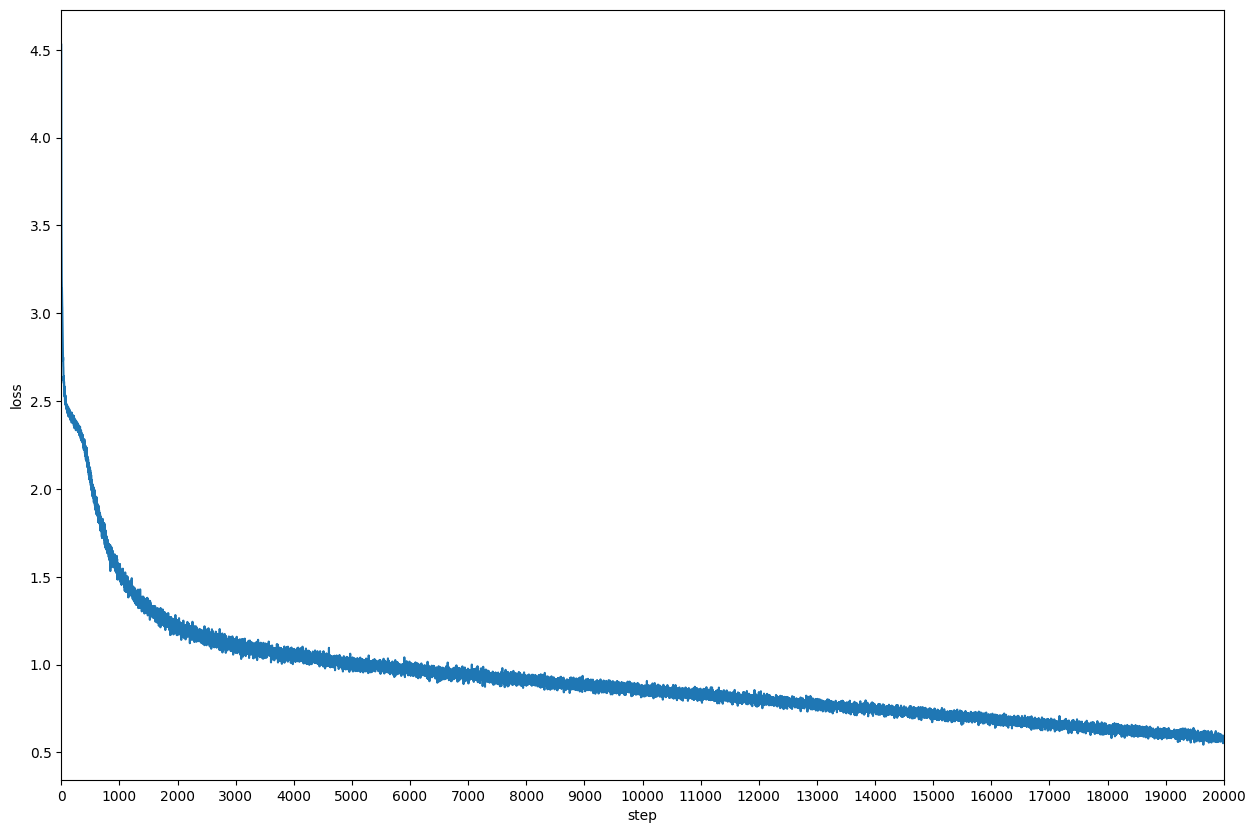

In [14]:
fig = plt.figure(figsize=(15, 10))
plt.xlabel('step')
plt.ylabel('loss')
plt.xlim(0, steps)
plt.xticks(list(range(0, steps + 1000, 1000)))
plt.plot(list(range(steps)), losses)

### test the model

In [14]:
def generate(model, text, n, temp=0.9, device='cpu'):
  assert len(text) > 0
  print(text, end='')
  it = torch.tensor(encode(text)).to(device)  # input tokens
  with torch.no_grad():
    for _ in range(n):
      p = F.softmax(model(it[-model.l:]) / temp, -1)[-1]  # prob distribution
      t = torch.multinomial(p, 1)  # next token
      it = torch.cat((it, t), -1)  # concatenate with prev tokens
      text += decode([t.item()])  # concatenate with prompt
      print(text[-1], end='')
    return text, it  # return completed text and tokens

In [18]:
_ = generate(model, 'Harry then went', 100, device=device)

Harry then went back to the comfortable 
again. “Harry, with three charging business 
all shooting your things out 

In [19]:
_ = generate(model, 'Voldemort cast his wand aside and', 500, device=device)

Voldemort cast his wand aside and increduling 

Page | 795 Harry Potter and the Deathly Hallows - J.K. Rowling 




and a red large creature with bronze rolling amongst 
the castle, so that filled the Hall of Houses to modest, 
finally and espretive books. Zos, come to resign 
over the basic he had many of the next House 
Page family members, have mistreated it because 
before they had his. 

Sirius sank had sunk to his brain, but Winky was 
pinned up and strayed straight. There was nothing 
secondary about Snape’s eyes, after 

In [20]:
_ = generate(model, 'Harry whirled the Nimbus in his hands', 4000, device=device)

Harry whirled the Nimbus in his hands. He noted 



Page | 624Harry Potter and the Order of the Phoenix - J.K. Rowling 




at last, for he stood listening against it: What did you 
dread Albus? Seven? He was right in a Muggle 
Portkey, for us who you are, I knew stranger to you 
later!” 

“Well, I was not eating I can see, my name,” said 
Dumbledore. “I know I know whether you are.” 

The dungeon followed at once. Harry watched out a 
track of torch portraits of a very important wizard’s 
life, and a moment later the grounds were called 
forward so that stood out three that he did not know 
and a beady planted while for them on top of the 
house to the rooms beside them. We used it univently 
relied of this order; four new front door in Harry 
and Albus Dumbledore, but it also for neither resembled 
whirled with perfumed sweetly glass boxes. Harry hastily 
grow of such a perrit in his resons and threw it out 
of the floor. 

“I would have had a last fortness at the old hags, 
I don’t 

### save the model checkpoint

In [ ]:
torch.save(model.state_dict(), '.pt')